
Fitted Phase Shift Parameters:
  ω₀ (fixed)       = 0.865400 Hz
  β                = 0.026728 (error: 0.006117)
  Inferred γ (2β)  = 0.053455 (error: 0.012234)

Fitted Amplitude (Lorentzian) Parameters:
  A₀               = 5.010270 (error: 0.109808)
  ω₀ (fixed)       = 0.865400 Hz
  γ                = 0.057318 (error: 0.002362)

Phase Shift Fit Chi-Squared:
  Chi-Squared         = 44.42293545677022
  Reduced Chi-Squared = 4.442293545677022

Amplitude Fit Chi-Squared:
  Chi-Squared         = 43.686600
  Reduced Chi-Squared = 4.854067


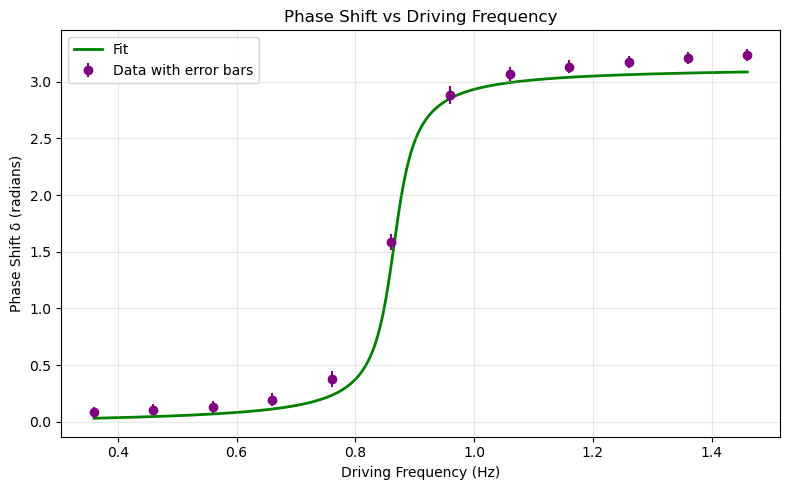

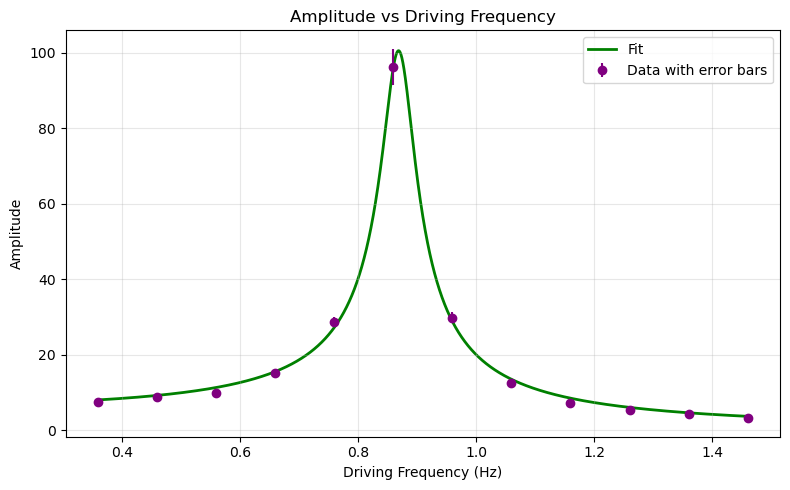

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.fft import fft, fftfreq
from scipy.optimize import curve_fit

# -----------------------------------------------------------
# Model Functions for Curve Fitting
# -----------------------------------------------------------
def phase_shift_model(omega, omega0, beta):
    """Phase shift model: φ(ω) = arccos((ω₀²–ω²)/sqrt((ω₀²–ω²)²+4ω²β²))"""
    numerator = omega0**2 - omega**2
    denominator = np.sqrt((omega0**2 - omega**2)**2 + 4 * omega**2 * beta**2)
    cos_delta = numerator / denominator
    return np.arccos(cos_delta)

def lorentzian(omega, A0, omega0, gamma):
    """Lorentzian function for amplitude fitting."""
    return A0 / np.sqrt((omega0**2 - omega**2)**2 + (gamma * omega)**2)

# -----------------------------------------------------------
# Data Extraction Functions (using FFT)
# -----------------------------------------------------------
def calculate_phase_points(omega_drives, all_times, all_amps, all_drives):
    """Calculate phase shift data points for each trial."""
    phase_data = []
    
    for trial_num, (omega_drive, time, amp, drive) in enumerate(zip(
            omega_drives, all_times, all_amps, all_drives)):
        
        # Clean data: remove NaN entries.
        valid_mask = ~(np.isnan(time) | np.isnan(amp) | np.isnan(drive))
        time = time[valid_mask]
        amp = amp[valid_mask]
        drive = drive[valid_mask]
        
        if len(time) < 2:
            print(f"Skipping Trial {trial_num+1} - insufficient data")
            continue

        dt = np.mean(np.diff(time))
        N = len(time)
        freqs = fftfreq(N, dt)
        
        idx = np.argmin(np.abs(freqs - omega_drive))
        
        amp_phase = np.angle(fft(amp)[idx])
        drive_phase = np.angle(fft(drive)[idx])
        
        # Compute phase difference with π–shift correction
        phase_diff = np.angle(np.exp(1j * (drive_phase - amp_phase))) + np.pi

        phase_data.append((omega_drive, phase_diff))
    
    return np.array(phase_data)

def calculate_amplitude_points(omega_drives, all_times, all_amps):
    """Calculate amplitude data points for each trial."""
    amplitude_data = []
    
    for trial_num, (omega_drive, time, amp) in enumerate(zip(omega_drives, all_times, all_amps)):
        valid_mask = ~(np.isnan(time) | np.isnan(amp))
        time = time[valid_mask]
        amp = amp[valid_mask]
        
        if len(time) < 2:
            print(f"Skipping Trial {trial_num+1} for amplitude - insufficient data")
            continue

        dt = np.mean(np.diff(time))
        N = len(time)
        freqs = fftfreq(N, dt)
        
        idx = np.argmin(np.abs(freqs - omega_drive))
        
        amp_magnitude = np.abs(fft(amp)[idx])
        amplitude_data.append((omega_drive, amp_magnitude))
        
    return np.array(amplitude_data)

# -----------------------------------------------------------
# Data Loading
# -----------------------------------------------------------
def load_data(file_path):
    df = pd.read_csv(file_path)
    
    times, amps, drives = [], [], []
    # We had 12 trials; adjust if necessary.
    for run in range(2, 14): 
        time_col = f'Time (s) Run #{run}'
        chA_col = f'Voltage, Ch A (V) Run #{run}'
        chB_col = f'Voltage, Ch B (V) Run #{run}'
        
        times.append(df[time_col].values)
        amps.append(df[chA_col].values)
        drives.append(df[chB_col].values)
    
    # Our driving frequencies (in Hz) hard-coded (adjust if needed)
    omega_drives = np.array([0.36, 0.46, 0.56, 0.66, 0.76, 0.86, 0.96, 1.06, 1.16, 1.26, 1.36, 1.46])
    
    return omega_drives, times, amps, drives

# -----------------------------------------------------------
# Fitting Functions and Error Extraction
# -----------------------------------------------------------
def fit_phase_shift(phase_points, p0_phase=[1.0, 0.1]):
    """Fit the phase shift data to the model and extract parameter errors."""
    popt, pcov = curve_fit(phase_shift_model, phase_points[:, 0], phase_points[:, 1], p0=p0_phase)
    perr = np.sqrt(np.diag(pcov))
    return popt, pcov, perr

def fit_amplitude(amplitude_points):
    """Fit the amplitude data to the Lorentzian and extract parameter errors."""
    max_index = np.argmax(amplitude_points[:, 1])
    A0_guess = amplitude_points[max_index, 1]
    omega0_guess = amplitude_points[max_index, 0]
    p0_amp = [A0_guess, omega0_guess, 0.1]
    
    popt, pcov = curve_fit(lorentzian, amplitude_points[:, 0], amplitude_points[:, 1], p0=p0_amp)
    perr = np.sqrt(np.diag(pcov))
    return popt, pcov, perr

# -----------------------------------------------------------
# Error Propagation for the Phase Shift Model
# -----------------------------------------------------------
def phase_shift_beta_derivative(omega, omega0, beta):
    """
    Compute the derivative dφ/dβ of the phase shift model.
    """
    numerator = 2 * (omega0**2 - omega**2) * omega
    denominator = (omega0**2 - omega**2)**2 + 4 * omega**2 * beta**2
    return np.abs(numerator / denominator)

# -----------------------------------------------------------
# Chi-Squared Calculation
# -----------------------------------------------------------
def chi_squared(y_data, y_model, y_err, dof):
    chi2 = np.sum(((y_data - y_model) / y_err)**2)
    reduced_chi2 = chi2 / dof
    return chi2, reduced_chi2

# -----------------------------------------------------------
# Plotting Functions (with error bars)
# -----------------------------------------------------------
def plot_phase_shift(phase_points, popt_phase, omega_drives, known_omega0=None, beta_error=None):
    """Plot phase shift data with error bars and the fitted model."""
    if known_omega0 is not None:
        omega0_used = known_omega0
    else:
        omega0_used = popt_phase[0]
    
    beta = popt_phase[1]
    frequencies = phase_points[:, 0]
    
    # Assume a measurement error for the phase data (e.g., 0.05 rad)
    sigma_phase_meas = 0.05
    
    # If a beta error is provided, propagate it to the phase using the derivative.
    if beta_error is None:
        beta_error = 0.0
    dphi_dbeta = phase_shift_beta_derivative(frequencies, omega0_used, beta)
    sigma_phase_prop = dphi_dbeta * beta_error
    
    # Total error on the phase data points:
    total_phase_error = np.sqrt(sigma_phase_meas**2 + sigma_phase_prop**2)
    
    plt.figure(figsize=(8, 5))
    plt.errorbar(phase_points[:, 0], phase_points[:, 1], yerr=total_phase_error,
                 fmt='o', color='purple', label='Data with error bars', zorder=2)
    
    omega_fit = np.linspace(np.min(omega_drives), np.max(omega_drives), 10000)
    plt.plot(omega_fit, phase_shift_model(omega_fit, omega0_used, beta),
             color="green", lw=2, label='Fit', zorder=1)
    
    plt.title('Phase Shift vs Driving Frequency')
    plt.xlabel('Driving Frequency (Hz)')
    plt.ylabel('Phase Shift δ (radians)')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_amplitude(amplitude_points, popt_amp, omega_drives):
    """Plot amplitude data with error bars and the fitted Lorentzian."""

    
    frequencies_amp = amplitude_points[:, 0]
    measured_amplitudes = amplitude_points[:, 1]
    # Assume a relative error of 5% for amplitude measurements.
    sigma_amp_meas = 0.05 * measured_amplitudes
    
    plt.figure(figsize=(8, 5))
    plt.errorbar(frequencies_amp, measured_amplitudes, yerr=sigma_amp_meas,
                 fmt='o', color='purple', label='Data with error bars', zorder=2)
    
    omega_fit = np.linspace(np.min(omega_drives), np.max(omega_drives), 10000)
    plt.plot(omega_fit, lorentzian(omega_fit, *popt_amp),
             color="green", lw=2, label='Fit', zorder=1)
    
    plt.title('Amplitude vs Driving Frequency')
    plt.xlabel('Driving Frequency (Hz)')
    plt.ylabel('Amplitude')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

# -----------------------------------------------------------
# Print Results (including parameter errors and chi-squared)
# -----------------------------------------------------------
def print_results(phase_points, amplitude_points, popt_phase, perr_phase, popt_amp, perr_amp, known_omega0=None):

    if known_omega0 is not None:
        omega0_used = known_omega0
        beta = popt_phase[1]
        beta_error = perr_phase[1]
    else:
        omega0_used = popt_phase[0]
        beta = popt_phase[1]
        beta_error = perr_phase[1]
    
    gamma_phase = 2 * beta
    gamma_phase_error = 2 * beta_error
    
    print("\nFitted Phase Shift Parameters:")
    if known_omega0 is not None:
        print(f"  ω₀ (fixed)       = {omega0_used:.6f} Hz")
    else:
        print(f"  ω₀               = {omega0_used:.6f} Hz (error: {perr_phase[0]:.6f})")
    print(f"  β                = {beta:.6f} (error: {beta_error:.6f})")
    print(f"  Inferred γ (2β)  = {gamma_phase:.6f} (error: {gamma_phase_error:.6f})")

    
    print("\nFitted Amplitude (Lorentzian) Parameters:")
    if known_omega0 is not None:
        print(f"  A₀               = {popt_amp[0]:.6f} (error: {perr_amp[0]:.6f})")
        print(f"  ω₀ (fixed)       = {omega0_used:.6f} Hz")
    else:
        print(f"  A₀               = {popt_amp[0]:.6f} (error: {perr_amp[0]:.6f})")
        print(f"  ω₀               = {popt_amp[1]:.6f} Hz (error: {perr_amp[1]:.6f})")
    print(f"  γ                = {popt_amp[2]:.6f} (error: {perr_amp[2]:.6f})")

    
    frequencies_phase = phase_points[:, 0]
    measured_phases = phase_points[:, 1]
    fitted_phases = phase_shift_model(frequencies_phase, omega0_used, beta)
    
    # Assume a measurement error for phase data (0.05 rad) and add the propagated uncertainty:
    sigma_phase_meas = 0.05
    dphi_dbeta = phase_shift_beta_derivative(frequencies_phase, omega0_used, beta)
    sigma_phase_prop = dphi_dbeta * beta_error
    total_phase_error = np.sqrt(sigma_phase_meas**2 + sigma_phase_prop**2)
    
    dof_phase = len(frequencies_phase) - 2 
    chi2_phase, red_chi2_phase = chi_squared(measured_phases, fitted_phases, total_phase_error, dof_phase)
    
    print("\nPhase Shift Fit Chi-Squared:")
    print(f"  Chi-Squared         = {chi2_phase}")
    print(f"  Reduced Chi-Squared = {red_chi2_phase}")
    

    
    frequencies_amp = amplitude_points[:, 0]
    measured_amplitudes = amplitude_points[:, 1]
    fitted_amplitudes = lorentzian(frequencies_amp, *popt_amp)
    
    # Assume a 5% relative error for the amplitude data:
    sigma_amp_meas = 0.05 * measured_amplitudes
    dof_amp = len(frequencies_amp) - 3  # three free parameters
    chi2_amp, red_chi2_amp = chi_squared(measured_amplitudes, fitted_amplitudes, sigma_amp_meas, dof_amp)
    
    print("\nAmplitude Fit Chi-Squared:")
    print(f"  Chi-Squared         = {chi2_amp:.6f}")
    print(f"  Reduced Chi-Squared = {red_chi2_amp:.6f}")

# -----------------------------------------------------------
# Main Function
# -----------------------------------------------------------
def main():
    # Specify the file path to your CSV data file.
    file_path = '/Users/willgray/Downloads/part-2-data-12trails(1).csv'
    
    # Load the experimental data.
    omega_drives, times, amps, drives = load_data(file_path)
    
    # Compute the FFT-based data points.
    phase_points = calculate_phase_points(omega_drives, times, amps, drives)
    amplitude_points = calculate_amplitude_points(omega_drives, times, amps)
    
    # Fit the data to the corresponding models.
    popt_phase, pcov_phase, perr_phase = fit_phase_shift(phase_points)
    popt_amp, pcov_amp, perr_amp = fit_amplitude(amplitude_points)
    
    # Optionally, set a known (fixed) natural frequency.
    known_omega0 = 0.8654  # for example, set to the desired value.
    
    # Print the fitted parameters, their uncertainties, and chi-squared values.
    print_results(phase_points, amplitude_points, popt_phase, perr_phase, popt_amp, perr_amp, known_omega0=known_omega0)
    
    # Plot the results with error bars.
    # For the phase plot, we use the fixed omega0 and the fitted β (with its error).
    plot_phase_shift(phase_points, popt_phase, omega_drives, known_omega0=known_omega0, beta_error=perr_phase[1])
    plot_amplitude(amplitude_points, popt_amp, omega_drives)

if __name__ == '__main__':
    main()